In [1]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
pwd

'/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master'

In [3]:
class ConfigClass():
    train_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/'
    test_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/testing/'   
    train_batch_size = 64
    train_num_epochs = 100

In [4]:
class SiameseDataset(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)
    
    
    
    
    

In [5]:
import os

train_dir = ConfigClass.train_dir
if os.path.isdir(train_dir):
    print(f"The train_dir '{train_dir}' exists and is accessible")
else:
    print(f"The train_dir '{train_dir}' does not exist or is not accessible")

The train_dir '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/' exists and is accessible


In [6]:
try:
    SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)
except Exception as e:
    print("An error occurred while accessing the image folder: ", e)

An error occurred while accessing the image folder:  name 'image_folder' is not defined


In [7]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

In [8]:
print("Image Folder: ", image_folder)
print("Siamese Dataset: ", siamese_dataset)

Image Folder:  Dataset ImageFolder
    Number of datapoints: 740
    Root location: /Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/
Siamese Dataset:  <__main__.SiameseDataset object at 0x7fc389be2ca0>


In [9]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

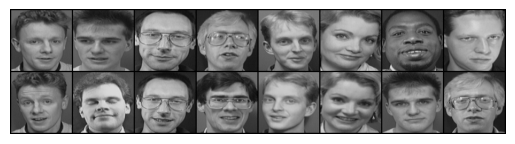

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [10]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

In [12]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        return contrastive_loss

In [13]:
print(torch.version.cuda)

None


In [14]:
print(output1.shape)
print(output2.shape)

NameError: name 'output1' is not defined

In [15]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cuXX/torch_stable.html



SyntaxError: invalid syntax (3878635041.py, line 1)

In [16]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork().cpu()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 2.9586145877838135
Epoch: 1 	 Loss: 1.0581042766571045
Epoch: 2 	 Loss: 0.5030894875526428
Epoch: 3 	 Loss: 0.44992947578430176
Epoch: 4 	 Loss: 0.3082832396030426
Epoch: 5 	 Loss: 0.2340560108423233
Epoch: 6 	 Loss: 0.07433723658323288
Epoch: 7 	 Loss: 0.1371888816356659
Epoch: 8 	 Loss: 0.05088992789387703
Epoch: 9 	 Loss: 0.053845569491386414
Epoch: 10 	 Loss: 0.04495584964752197
Epoch: 11 	 Loss: 0.044109947979450226
Epoch: 12 	 Loss: 0.029170192778110504
Epoch: 13 	 Loss: 0.04185473918914795
Epoch: 14 	 Loss: 0.042678505182266235
Epoch: 15 	 Loss: 0.03427729383111
Epoch: 16 	 Loss: 0.04070932790637016
Epoch: 17 	 Loss: 0.019531410187482834
Epoch: 18 	 Loss: 0.04309790953993797
Epoch: 19 	 Loss: 0.0315827876329422
Epoch: 20 	 Loss: 0.03612188249826431
Epoch: 21 	 Loss: 0.02138511836528778
Epoch: 22 	 Loss: 0.025462837889790535
Epoch: 23 	 Loss: 0.010946770198643208
Epoch: 24 	 Loss: 0.017542537301778793
Epoch: 25 	 Loss: 0.04668130353093147
Epoch: 26 	 Loss: 0.0379

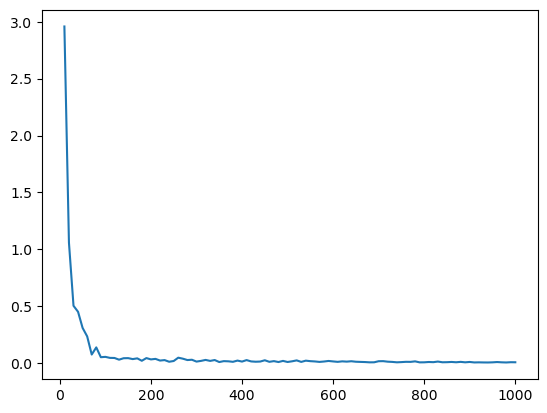

In [17]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cpu(), input2.cpu(), label.cpu()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
show_plot(counter, loss_history)

Iteration 1


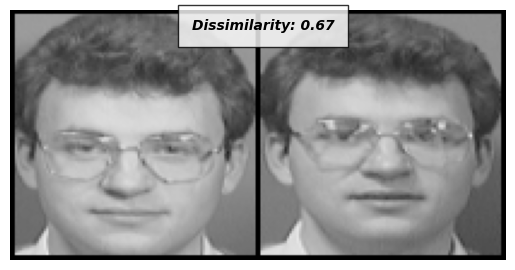

Iteration 2


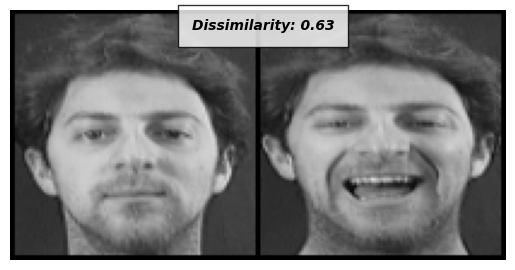

Iteration 3


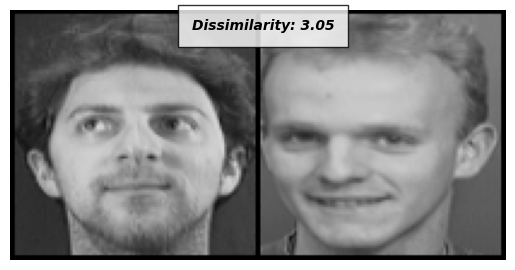

Iteration 4


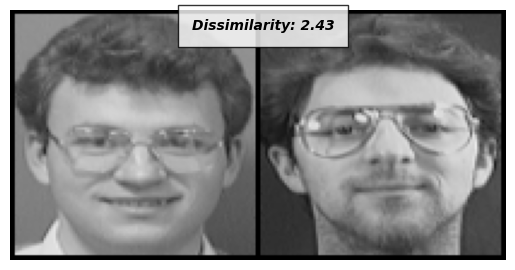

Iteration 5


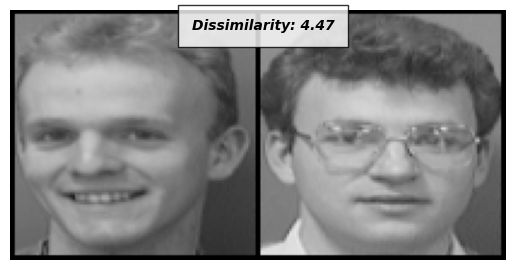

Iteration 6


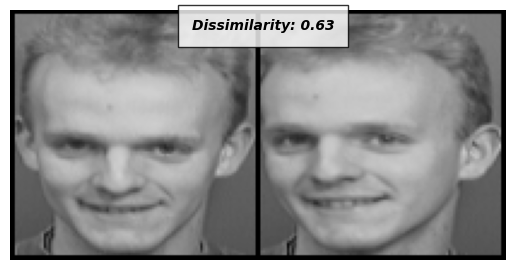

Iteration 7


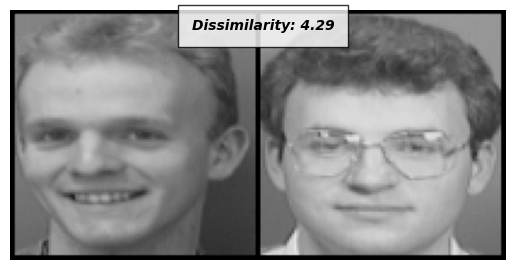

Iteration 8


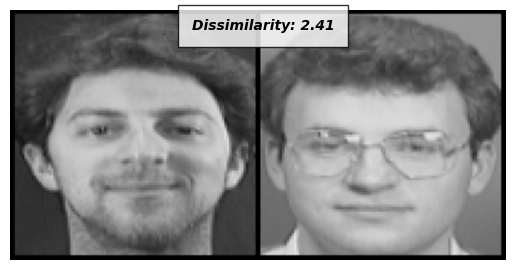

Iteration 9


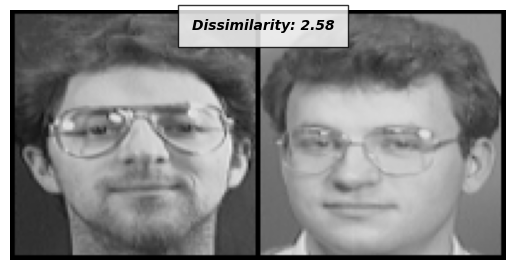

Iteration 10


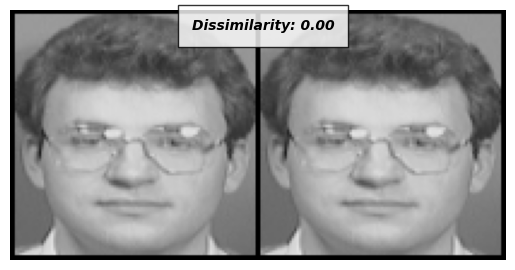

Accuracy: 0.80

Confusion Matrix:
 [[5 1]
 [1 3]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



In [24]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(dataloader)
threshold = 1
correct = 0
total = 0
y_true = None
y_pred = None
    
for i in range(10):
    img0, _, _ = next(data_iter)
    _, img1, label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    
    output1, output2 = model(Variable(img0).cpu(), Variable(img1).cpu())
    distance = F.pairwise_distance(output1, output2)
    y_pred_now = [1 if d < threshold else 0 for d in distance]
    y_true_now = [label_tensor.item() for _, _, (label_tensor,) in zip(img0, img1, label)]

    if y_true is None:
        y_true = y_true_now
        y_pred = y_pred_now
    else:
        y_true.extend(y_true_now)
        y_pred.extend(y_pred_now)

    print(f"Iteration {i+1}")
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))
    for pred, true in zip(y_pred_now, y_true_now):
        if pred == true:
            correct += 1
        total += 1
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
